## Problem Statement: Instacart is stuggling with its increasing warehousing costs, recommend ways to reduce it.

My approach:

To reduce the warehousing costs, proper inventory management is required. In this notebook, market research is done utilizing the dataset of orders, opensourced by Instacart, which will help in identifying the products, departments, aisles that are not important and can be removed from the warehouses, thus reducing warehousing costs.

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from functools import partial # to reduce df memory consumption by applying to_numeric
color = sns.color_palette() # adjusting plotting style
import warnings
warnings.filterwarnings('ignore') # silence annoying warnings

In [2]:
order_products_train = pd.read_csv('order_products__train.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')

### Firstly lets look at order table

In [3]:
orders.head(5)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


### At what hours people are ordering the most

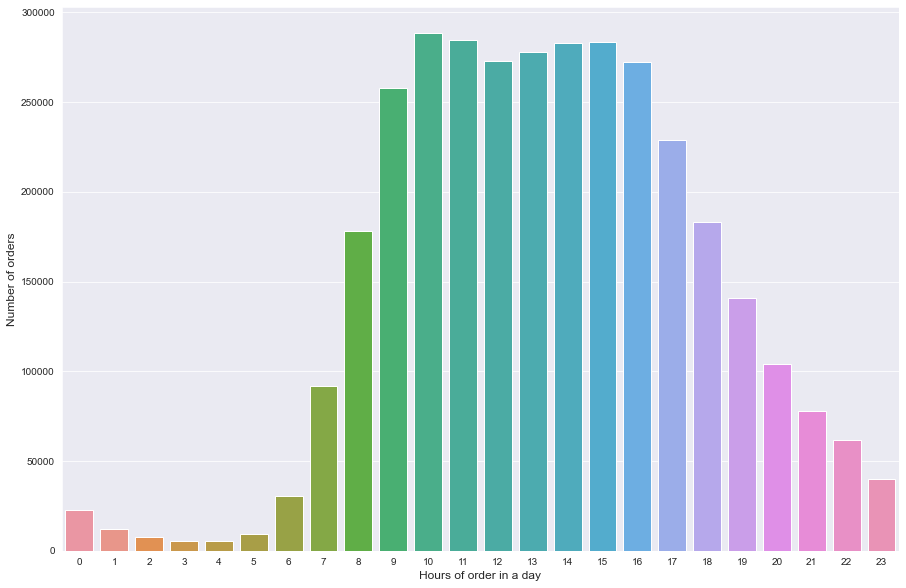

In [4]:
grouped_time = orders.groupby("order_id")["order_hour_of_day"].aggregate("sum").reset_index()
grouped_time = grouped_time.order_hour_of_day.value_counts()

sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(grouped_time.index, grouped_time.values)
plt.ylabel('Number of orders', fontsize=12)
plt.xlabel('Hours of order in a day', fontsize=12)
plt.show()

Most of the people order after** 9 am** and the statistics are almost steady till **3 pm**, but after 4 pm, numbers of order decline!

### On which days people are ordering the most?

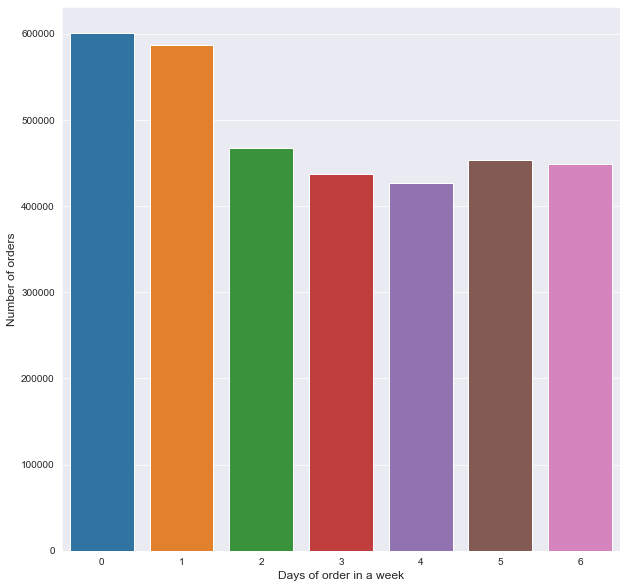

In [5]:
grouped_days = orders.groupby("order_id")["order_dow"].aggregate("sum").reset_index()
grouped_days = grouped_days.order_dow.value_counts()

f, ax = plt.subplots(figsize=(10, 10))
sns.barplot(grouped_days.index, grouped_days.values)
plt.ylabel('Number of orders', fontsize=12)
plt.xlabel('Days of order in a week', fontsize=12)
plt.show()

**Monday** and **Tuesday** are the days in which relative number of orders are lightly higher!

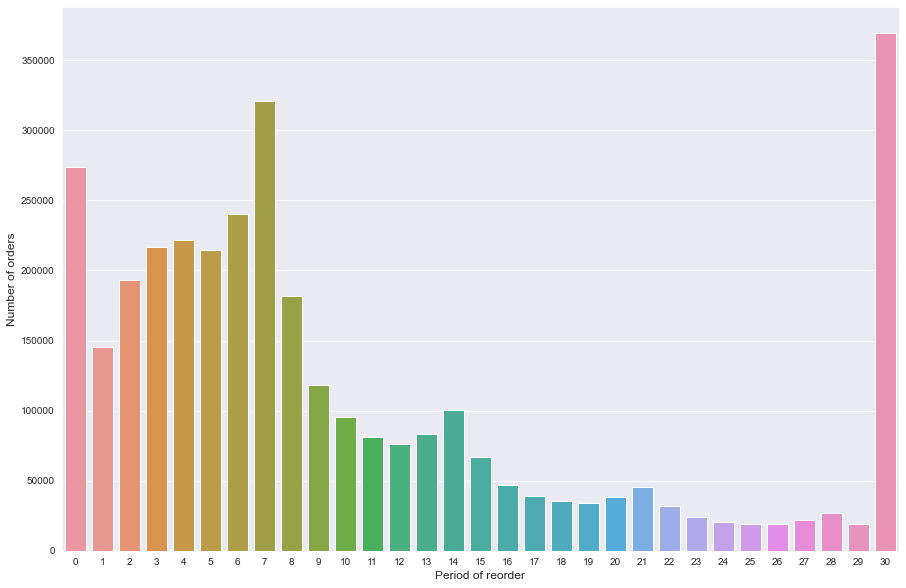

In [6]:
grouped_redays = orders.groupby("order_id")["days_since_prior_order"].aggregate("sum").reset_index()
grouped_redays = grouped_redays.days_since_prior_order.value_counts()

from matplotlib.ticker import FormatStrFormatter
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(grouped_redays.index, grouped_redays.values)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.ylabel('Number of orders', fontsize=12)
plt.xlabel('Period of reorder', fontsize=12)
plt.show()

**It looks like there are a lot of offers on 30th!** **haha!**

Let's look at the order_products_train and order_products_prior files now. The products purchased in each order are listed in these files. More particular, order_products_prior holds the contents of past orders for all customers, whereas order_products_train only includes the contents of recent orders for a subset of customers.

In [7]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [8]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [9]:
print("The order_products_train size is : ", order_products_train.shape)
print("The order_products_prior size is : ", order_products_prior.shape)

The order_products_train size is :  (1384617, 4)
The order_products_prior size is :  (32434489, 4)


In [10]:
order_products_all = pd.concat([order_products_train, order_products_prior], axis=0)

In [11]:
order_products_all.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [12]:
orders_unique = len(set(order_products_all.order_id))
products_unique = len(set(order_products_all.product_id))
print("For %s products there are %s orders" %(products_unique, orders_unique))

For 49685 products there are 3346083 orders


### Count of product orders per customer

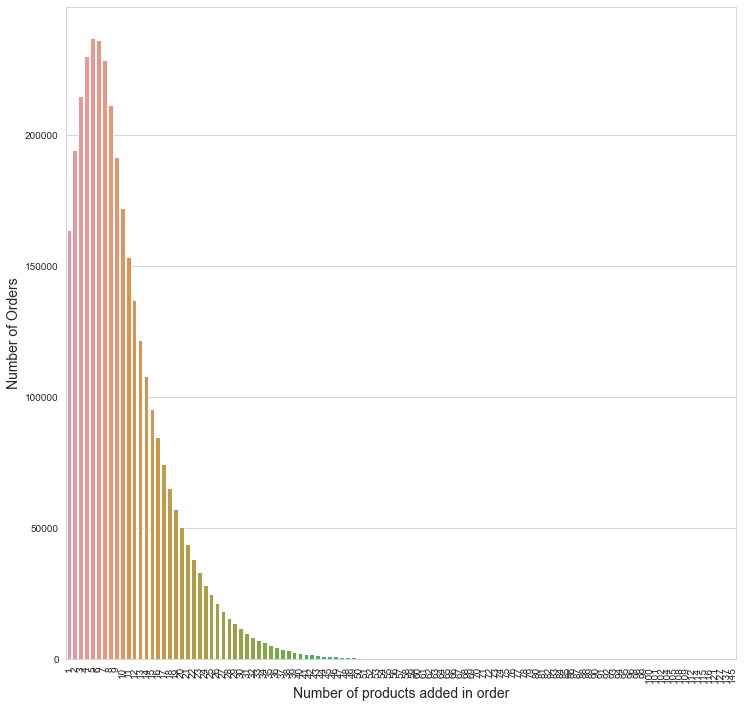

In [13]:
grouped_count = order_products_all.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
grouped_count = grouped_count.add_to_cart_order.value_counts()

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(12, 12))
plt.xticks(rotation='vertical')
sns.barplot(grouped_count.index, grouped_count.values)

plt.ylabel('Number of Orders', fontsize=14)
plt.xlabel('Number of products added in order', fontsize=14)
plt.show()

Most of the people order around 4 to **6** products

### Most ordered products

In [14]:
grouped = order_products_all.groupby("product_id")["reordered"].aggregate(Total_reorders = 'count').reset_index()
grouped = pd.merge(grouped, products[['product_id', 'product_name']], how='left', on=['product_id'])
grouped = grouped.sort_values(by='Total_reorders', ascending=False)[:]
grouped

,product_id,Total_reorders,product_name
24849,24852,491291,Banana
13173,13176,394930,Bag of Organic Bananas
21134,21137,275577,Organic Strawberries
21900,21903,251705,Organic Baby Spinach
47205,47209,220877,Organic Hass Avocado
...,...,...,...
35887,35890,1,Petite Black Eyed Peas
13394,13397,1,"Molasses, Bead"
15385,15388,1,Orange Flavored Ice Cubes
35949,35952,1,Peachtree Schnapps


*   This was really unexpected! **Banana** is the most ordered product!!!
*   Fruits are ordered much more than vegetables!




### Are people ordering the previously ordered product?

In [15]:
grouped_prevre = order_products_all.groupby("reordered")["product_id"].aggregate(Total_products = 'count').reset_index()
grouped_prevre['Ratios'] = grouped_prevre["Total_products"].apply(lambda x: x /grouped_prevre['Total_products'].sum())
grouped_prevre

,reordered,Total_products,Ratios
0,0,13863746,0.409938
1,1,19955360,0.590062


**59%** of the products ordered are the ones that were previously ordered by the customer

### Products which are mostly reordered?

In [16]:
grouped_reorder = order_products_all.groupby("product_id")["reordered"].aggregate(reorder_sum = 'sum',reorder_total = 'count').reset_index()
grouped_reorder['reorder_probability'] = grouped_reorder['reorder_sum'] / grouped_reorder['reorder_total']
grouped_reorder = pd.merge(grouped_reorder, products[['product_id', 'product_name']], how='left', on=['product_id'])

grouped_reorder = grouped_reorder[grouped_reorder.reorder_total > 75].sort_values(['reorder_probability'], ascending=False)[:10]
grouped_reorder

,product_id,reorder_sum,reorder_total,reorder_probability,product_name
2074,2075,84,90,0.933333,Serenity Ultimate Extrema Overnight Pads
27737,27740,94,102,0.921569,Chocolate Love Bar
35601,35604,93,104,0.894231,Maca Buttercups
38248,38251,99,111,0.891892,Benchbreak Chardonnay
36798,36801,88,99,0.888889,Organic Blueberry B Mega
10233,10236,114,131,0.870229,Fragrance Free Clay with Natural Odor Eliminat...
20595,20598,99,114,0.868421,Thousand Island Salad Snax
5455,5457,78,90,0.866667,Classic Carbonated Natural Mineral Water
35493,35496,394,457,0.862144,Real2 Alkalized Water 500 ml
9289,9292,2580,2995,0.861436,Half And Half Ultra Pasteurized


**Sanitary Pads** , **Chocolates** and some **Personal care** items tops the reorderd list

### Which departments are most important?

In [17]:
items  = pd.merge(left =pd.merge(left=products, right=departments, how='left'), right=aisles, how='left')
items.head()

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,2,All-Seasons Salt,104,13,pantry,spices seasonings
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages,tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen,frozen meals
4,5,Green Chile Anytime Sauce,5,13,pantry,marinades meat preparation


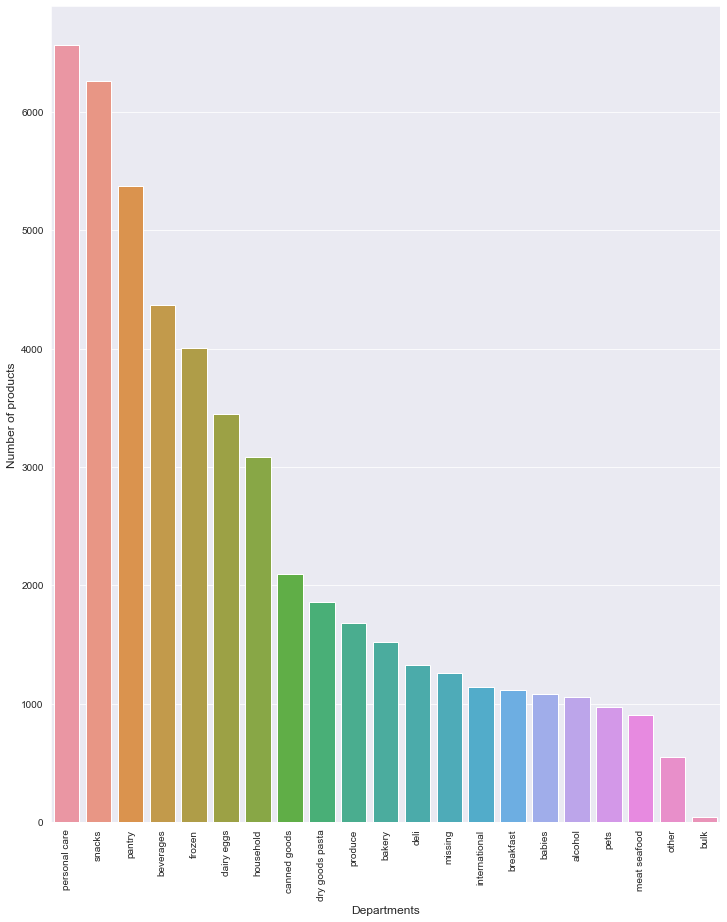

In [18]:
grouped_dept = items.groupby("department")["product_id"].aggregate(Total_products = 'count').reset_index()
grouped_dept['Ratio'] = grouped_dept["Total_products"].apply(lambda x: x /grouped_dept['Total_products'].sum())

grouped_dept  = grouped_dept.groupby(['department']).sum()['Total_products'].sort_values(ascending=False)

sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(12, 15))
plt.xticks(rotation='vertical')
sns.barplot(grouped_dept.index, grouped_dept.values)
plt.ylabel('Number of products', fontsize=12)
plt.xlabel('Departments', fontsize=12)
plt.show()

*   **Personal Care**, **Snacks** and **Pantry** department tops the list
*   Daily needed stuff departments, such as **Dairy**, **Frozen Food** and **bakery** are very important



### Which Aisles are the most important?

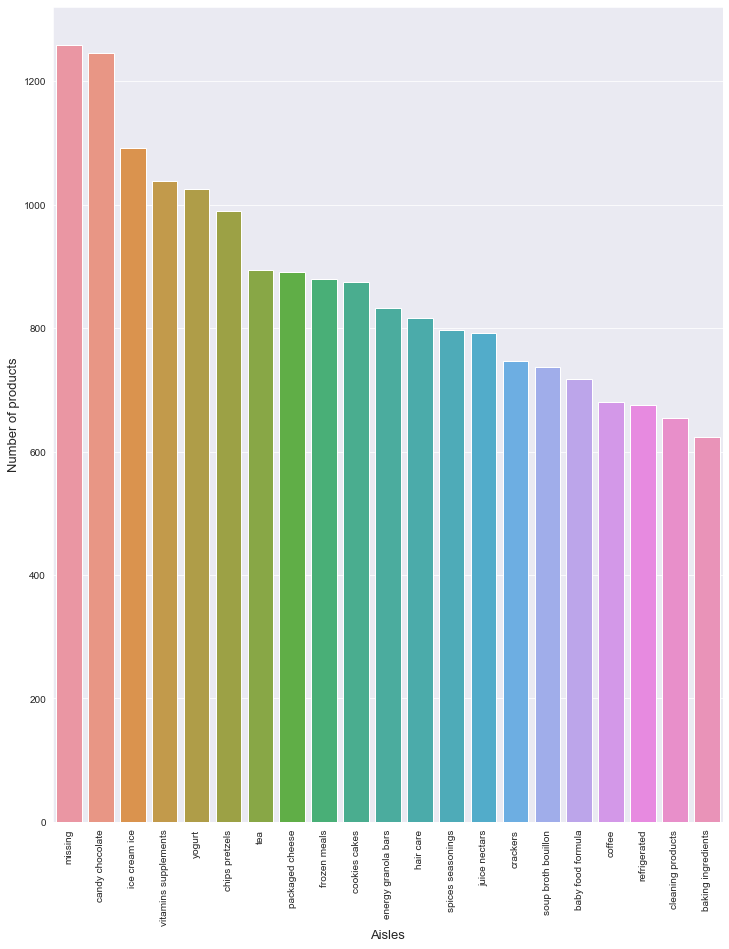

In [19]:
grouped_aisles = items.groupby("aisle")["product_id"].aggregate(Total_products='count').reset_index()
grouped_aisles['Ratio'] = grouped_aisles["Total_products"].apply(lambda x: x /grouped_aisles['Total_products'].sum())
grouped_aisles  = grouped_aisles.groupby(['aisle']).sum()['Total_products'].sort_values(ascending=False)[:21]

f, ax = plt.subplots(figsize=(12, 15))
plt.xticks(rotation='vertical')
sns.barplot(grouped_aisles.index, grouped_aisles.values)
plt.ylabel('Number of products', fontsize=13)
plt.xlabel('Aisles', fontsize=13)
plt.show()

**Chocolate and Ice-Cream** VS **Vitamin Supplement and Yougurt**




### Observations:
Below mentioned are some pointers, for details and full lists, look at the updated notebook and sorted lists of department, aisles and products

Most important aisles are: Candy chocolate, Fresh Fruits, Yogurt, Vitamins Supplements, Chips, Fresh Vegetables

Least important aisles are: Baby accessories, Frozen Juice, Packaged seafood, Frozen bread doughs, Fresh herbes

Fruits are ordered more than vegetables

Most important departments: Personal Care, Snacks and Pantry

Least importnat departments: Bulk, Meat seafood, Alcohol and Babies

41% of the products are not reordered, but its important to note that Sanitary pads, Chocolates and Personal care items, tops reordered list

Number of orders are quite low on thursday and friday(this is important only if we can manage warehouse inventory on daily basis)